# Сборный проект

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Ревьюеру привет) Хотел успеть сделать больше, но никак не могу успеть, поэтому отправляю что есть, надеюсь на понимание. Хочу после проверки исправить все замечания что будут, довести его до конца и написать общий вывод, так же промежуточные выводы. В этом проекте как-то тяжело следить за порядком, надеюсь понятно хоть сделано все)(первая итерация)

</div>

## 1. Установка библиотек и загрузка данных

In [1]:
#!pip install transformers -q
#!pip uninstall tensorflow keras -y
#!pip install tensorflow==2.12.0
#!pip install -U huggingface_hub -q
#!pip install catboost -q
#!pip install tensorflow.keras
#use python<=3.8.11

In [104]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, BertModel
from tensorflow.keras.metrics import RootMeanSquaredError
from PIL import Image


In [ ]:
#для загрузки данных создадим функцию для чтения файла и проверки существования пути
pth_1 = 'D:/combine_4/train_dataset.csv'
pth_2 = 'D:/combine_4/test_queries.csv'
pth_3 = 'D:/combine_4/test_images.csv'
#pth_4 = 'D:/combine_4/CrowdAnnotations.tsv' - их в этом проекте не использую
pth_5 = 'D:/combine_4/ExpertAnnotations.tsv'

def file_read(path, sep, names=None, index=None):
    try:
        data = pd.read_csv(path, sep=sep, names=names, index_col=index)
    except FileNotFoundError:
        print("Ошибка: Файл не найден.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    return data

In [4]:
train_queries = file_read(pth_1, ',',)
display(train_queries.head())
train_queries.info()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
test_queries = file_read(pth_2, '|', index=['Unnamed: 0'])
display(test_queries.head())
test_queries.info()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [6]:
test_images = file_read(pth_3, ',')
display(test_images.head())
test_images.info()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [7]:
expert_annotations = file_read(pth_5, '\t', names=['image', 'query_id', 'first_expert', 'second_expert', 'third_expert'])
display(expert_annotations.head())
expert_annotations.info()

,image,query_id,first_expert,second_expert,third_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5822 non-null   object
 1   query_id       5822 non-null   object
 2   first_expert   5822 non-null   int64 
 3   second_expert  5822 non-null   int64 
 4   third_expert   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


Данные загружены и просмотрены. Несоответсвия содержания с названиями колонок не обнаружили, стиль написания некоторых таблиц был приведен к змеиному стилю. Пропусков в данных не обнаружено, проверим дополнительно нет ли дублирующихся строк.

Так как в нашем распоряжении есть оценки с крауд-сервиса и экспертные, выберем те которым можно больше доверять.  
В случае нашей работы хорошим решением будет доверится экспертной оценке и на их основе сделать одну общую.  
Общую оценку сделаем ссуммировав все оценки экспертов и выбрав для сумм уровень доверия в интервале от 0 до 1, где 0 - полностью не соответствует запросу, а 1 - полностью соответсвует запросу, при этом значения между ними понимаются как вероятность соответствия изображения запросу.

## 2. Предобработка данных и исследование

In [8]:
#для проверки на дубликаты используем функцию
def completeness_check(ittor, table):
    value = ittor.duplicated().sum()
    print(f'Полных дубликатов в таблице {table} - {value}')

In [9]:
completeness_check(train_queries, 'c тренировочными запросами')

Полных дубликатов в таблице c тренировочными запросами - 0


In [10]:
completeness_check(test_queries, 'c тестовыми запросами')

Полных дубликатов в таблице c тестовыми запросами - 0


In [11]:
completeness_check(test_images, 'c тестовыми изображениями')

Полных дубликатов в таблице c тестовыми изображениями - 0


In [12]:
completeness_check(expert_annotations, 'c аннотациями експертов')

Полных дубликатов в таблице c аннотациями експертов - 0


Дубликатов не обнаружили. Теперь объеденим колонки с оценками взяв их сумму.

In [13]:

expert_annotations['combined_mark'] = expert_annotations['first_expert'] + expert_annotations['second_expert'] + expert_annotations['third_expert']
display(expert_annotations.head())

,image,query_id,first_expert,second_expert,third_expert,combined_mark
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,3
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,4
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,4
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,5
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,4


In [14]:
#для разбивки сумм на вероятности, воспользуемся функцией
def probs(row):
    sum = row['combined_mark']
    if sum <= 4:
        return 0
    if sum <= 6:
        return 0.1
    if sum <= 8:
        return 0.3
    if sum == 9:
        return 0.6
    if sum == 10:
        return 0.75
    if sum == 11:
        return 0.9
    if sum == 12:
        return 1

In [15]:
#применим функцию, для получения новых оценок
expert_annotations['probabilities'] = expert_annotations.apply(probs, axis=1)
display(expert_annotations.head())

,image,query_id,first_expert,second_expert,third_expert,combined_mark,probabilities
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,3,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,4,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,4,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,5,0.1
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,4,0.0


In [16]:
#объединим таблицы с тренировочными данными и экспертными запросами
train_with_marks = pd.merge(train_queries, expert_annotations, on=['image', 'query_id'], how='left')
display(train_with_marks.head())

train_with_marks.shape

,image,query_id,query_text,first_expert,second_expert,third_expert,combined_mark,probabilities
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,5,0.1
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,12,1.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0


(5822, 8)

Проанализируем столбец с оценками с помощью графика

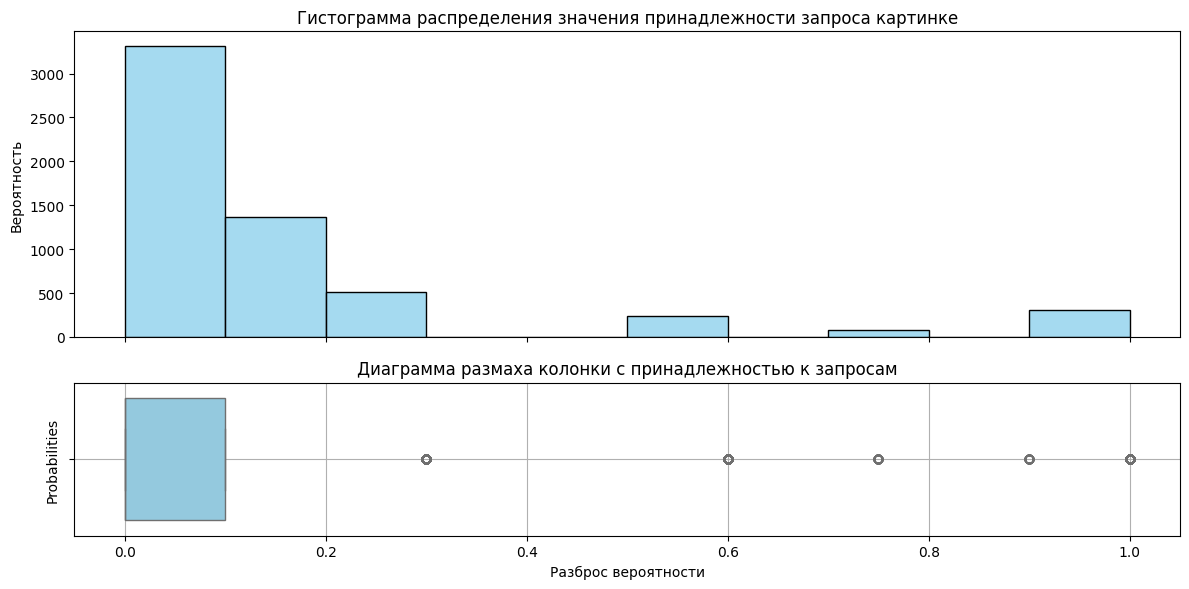

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(12, 6))

sns.histplot(train_with_marks['probabilities'], bins=10, kde=False, ax=ax1, color='skyblue')
ax1.set_title('Гистограмма распределения значения принадлежности запроса картинке')
ax1.set_ylabel('Вероятность')

sns.boxplot(x=train_with_marks['probabilities'], ax=ax2, color='skyblue')
ax2.set_title('Диаграмма размаха колонки c принадлежностью к запросам')
ax2.set_xlabel('Разброс вероятности')
ax2.set_ylabel('Probabilities')
plt.grid('True')

plt.tight_layout()
plt.show()

Судя по графику разброса большая часть изображений не соответсвует их описанию, если доверится экспертной оценке. Те что соответствуют ящик с усами считает выбросами, что на самом деле не так. Эти данные пригодятся при фильтрации запросов под закон о распространении информации.

Для исполнения правил использования изображений с детьми до 16 лет необходимо отобрать фотографии, на которых по описанию могут присутствовать дети и исключить их из общей выборки. Для более корректного отбора воспользуемся оценками экспертов с уровнем уверенности не менее 0.7, чтобы в запрос попали только изображения с действительно нарушающими правила изображениями.

In [18]:
#для выделения нужных слов описывающих возраст детей до 16 лет воспользуемся регулярным
#выражением и исключим из таблицы изображения, которые могут нарушать правила обработки изображений
res = train_with_marks['query_text'].str.contains(r"'boy|boys|girl|girls|child|children|baby|newborn|kid|kids|teenager|teen|junior")

print(len(train_with_marks[res].image.unique().tolist()),
      len(train_with_marks.image.unique().tolist()))

train_with_marks_clear = train_with_marks[~((train_with_marks.image.isin(train_with_marks[res].image.unique().tolist()))
                                                 & (train_with_marks['probabilities'] >= 0.3))].copy()
train_with_marks_clear = train_with_marks_clear.reset_index(drop=True)
train_with_marks_clear.shape


609 1000


(5240, 8)

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Нужно ли оставлять по итогу только уникальные изображения или можно использовать весь датасет? Если нужно, то как это лучше сделать учитывая мою фильтрацию с помощью оценок экспертов?(первая итерация)

</div>

Для перевода изображений в вектор воспользуемся классом ImageDataGenerator из библиотеки tensorflow

In [93]:
def load_train(path, df):
    train_datagen = ImageDataGenerator(#rotation_range=(45),
                                       #vertical_flip=True,
                                       rescale=1./255) 
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                              directory=path,
                                              x_col='image',
                                              y_col='probabilities',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              shuffle=False,
                                              class_mode='raw',
                                              subset='training',
                                              seed=5678)
    
    return train_datagen_flow

def load_test(path, df):
    test_datagen = ImageDataGenerator(rescale=1./255)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                              directory=path,
                                              x_col='image',
                                              y_col=None,
                                              target_size=(224, 224),
                                              shuffle=False,
                                              batch_size=16,
                                              class_mode=None,
                                              seed=5678)
    
    return test_datagen_flow

In [ ]:
#загрузим изображения
train_images = load_train('D:combine_4/train_images', train_with_marks_clear)

Found 5240 validated image filenames.


In [ ]:
#инициализируем модель для получения векторов
def image_model(input_shape):
    model = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    pooling='avg',
                    include_top=False)
    return model

Как в код ниже можно добавить реализацию прогресс бара из nltk?

In [ ]:
#пропустим модель через изображения
resnet = image_model((224, 224, 3))
image_vector = resnet.predict(train_images, verbose=2)

328/328 - 824s - 824s/epoch - 3s/step


In [ ]:
#сохраним изображения в отдельном столбце, предварительно поменяв их размерность и тип
image_embedding = image_vector.reshape(image_vector.shape[0], -1)

train_with_marks_clear['image_embedding'] = list(image_embedding)
display(train_with_marks_clear.head())

,image,query_id,query_text,first_expert,second_expert,third_expert,combined_mark,probabilities,image_embedding
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.007829939, 0.0, 1.2201952, 0.0, 0..."
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0, 0.0, 0.9342685, 0.0, 0.0, 0.62..."
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,5,0.1,"[0.0, 0.0, 0.0018150831, 0.0, 1.2082343, 0.0, ..."
3,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0, 0.0, 1.2475461, 0.0, 0.0, 1.00..."
4,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0014419653, 0.0, 0.99058235, 0.0,..."


Теперь переведем текст в ембедингы для обучения модели

In [ ]:
#иниициализируем токенизатор для текста
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#токенизируем запросы нашего датасета
train_with_marks_clear['text_embeddings'] = train_with_marks_clear['query_text'].apply(lambda x: np.array(tokenizer.encode(x, padding='max_length')))
display(train_with_marks_clear.head())

,image,query_id,query_text,first_expert,second_expert,third_expert,combined_mark,probabilities,image_embedding,text_embeddings
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.007829939, 0.0, 1.2201952, 0.0, 0...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175..."
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0, 0.0, 0.9342685, 0.0, 0.0, 0.62...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175..."
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,5,0.1,"[0.0, 0.0, 0.0018150831, 0.0, 1.2082343, 0.0, ...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175..."
3,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0, 0.0, 1.2475461, 0.0, 0.0, 1.00...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175..."
4,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0014419653, 0.0, 0.99058235, 0.0,...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175..."


In [26]:
#объединим два вектора в один, чтобы преобразовать его в тензор при обучении модели
train_with_marks_clear['concat_emb'] = train_with_marks_clear.apply(
    lambda x: np.concatenate([x['image_embedding'], x['text_embeddings']]), axis=1)
train_with_marks_clear['concat_emb'].iloc[0].shape

(2560,)

Теперь после получения нужных векторов приступим к обучению модели и получению предсказаний.

## 3. Обучение моделей

In [27]:
#для разбивки данных воспользуемся методом GroupShuffleSplit из библиотеки sklearn чтобы исключить попадение одного и того-же изображения в обе выборки 
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
#создадим колонку для группировки по уникальным сочетаниям изображение-запрос
train_with_marks_clear['gs_group_key'] = train_with_marks_clear['image'].astype(str) + '_' + train_with_marks_clear['query_id'].astype(str)
#теперь сгруппируем данные
train_indices, test_indices = next(gss.split(X=train_with_marks_clear.drop(columns=['probabilities']),
                                            y=train_with_marks_clear['probabilities'],
                                            groups=train_with_marks_clear['gs_group_key']))

train_df, test_df = train_with_marks_clear.iloc[train_indices], train_with_marks_clear.iloc[test_indices]
train_df.head()

,image,query_id,query_text,first_expert,second_expert,third_expert,combined_mark,probabilities,image_embedding,text_embeddings,concat_emb,gs_group_key
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.007829939, 0.0, 1.2201952, 0.0, 0...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...","[0.0, 0.0, 0.007829939015209675, 0.0, 1.220195...",1056338697_4f7d7ce270.jpg_2549968784_39bfbe44f...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0, 0.0, 0.9342685, 0.0, 0.0, 0.62...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...","[0.0, 0.0, 0.0, 0.0, 0.9342684745788574, 0.0, ...",1262583859_653f1469a9.jpg_2549968784_39bfbe44f...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,5,0.1,"[0.0, 0.0, 0.0018150831, 0.0, 1.2082343, 0.0, ...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...","[0.0, 0.0, 0.0018150830874219537, 0.0, 1.20823...",2447284966_d6bbdb4b6e.jpg_2549968784_39bfbe44f...
3,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.0, 0.0, 1.2475461, 0.0, 0.0, 1.00...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...","[0.0, 0.0, 0.0, 0.0, 1.2475460767745972, 0.0, ...",2621415349_ef1a7e73be.jpg_2549968784_39bfbe44f...
5,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,3,0.0,"[0.0, 0.0, 0.018638976, 0.011048497, 0.9585813...","[101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...","[0.0, 0.0, 0.018638975918293, 0.01104849670082...",3222041930_f642f49d28.jpg_2549968784_39bfbe44f...


In [ ]:
#отбросим ненужные колонки для модели и создадим тренировочные выборки
columns_to_drop = ['image', 'gs_group_key',
                   'query_id', 'query_text',
                   'first_expert', 'second_expert',
                    'third_expert', 'combined_mark',
                    'probabilities', 'image_embedding',
                    'text_embeddings']
X_train = train_df.drop(columns_to_drop, axis=1)
X_test = test_df.drop(columns_to_drop, axis=1)
y_train = train_df['probabilities'].values
y_test = test_df['probabilities'].values

#признаки для тренировки линейной регрессии
X_train_lr = np.vstack(X_train['concat_emb'].values)
X_test_lr = np.vstack(X_test['concat_emb'].values)

In [ ]:
#признаки для нейронной сети
X_train_tf = tf.convert_to_tensor(np.vstack(X_train['concat_emb'].values))
X_test_tf = tf.convert_to_tensor(np.vstack(X_test['concat_emb'].values))


Обучим линейную регрессию для сравнения результатов с другими более сложными моделями

In [ ]:
#инициализируем и обучим модель линейной регрессии
model = LinearRegression(n_jobs=-1)
cv = cross_validate(model, X_train_lr, y_train, scoring='neg_root_mean_squared_error')
print(f'Медианная метрика модели за пять итераций обучения - {round(-np.median(cv["test_score"]), 2)}')

Метрика модели - 1055667.62


In [ ]:
#инициализируем модель использующу градиентный спуск для получения предсказания
cat = CatBoostRegressor(grow_policy='Depthwise',
                        learning_rate=0.0001,
                        random_state=5678,
                        early_stopping_rounds=10,
                        iterations=30,
                        verbose=10)

param = {
    'depth': range(5, 15)
}

random_cat = RandomizedSearchCV(cat, param, n_iter=10, scoring='neg_root_mean_squared_error', random_state=5678)
random_cat.fit(X_train_lr, y_train)

0:	learn: 0.1996858	total: 348ms	remaining: 10.1s
10:	learn: 0.1996600	total: 2.74s	remaining: 4.73s
20:	learn: 0.1996346	total: 4.99s	remaining: 2.14s
29:	learn: 0.1996117	total: 6.9s	remaining: 0us
0:	learn: 0.1958558	total: 201ms	remaining: 5.82s
10:	learn: 0.1958301	total: 2.31s	remaining: 4s
20:	learn: 0.1958061	total: 4.51s	remaining: 1.93s
29:	learn: 0.1957830	total: 6.45s	remaining: 0us
0:	learn: 0.2017535	total: 218ms	remaining: 6.31s
10:	learn: 0.2017276	total: 2.33s	remaining: 4.03s
20:	learn: 0.2017000	total: 4.49s	remaining: 1.93s
29:	learn: 0.2016759	total: 6.47s	remaining: 0us
0:	learn: 0.2050814	total: 223ms	remaining: 6.46s
10:	learn: 0.2050560	total: 2.34s	remaining: 4.04s
20:	learn: 0.2050289	total: 4.46s	remaining: 1.91s
29:	learn: 0.2050053	total: 6.33s	remaining: 0us
0:	learn: 0.2020187	total: 196ms	remaining: 5.67s
10:	learn: 0.2019955	total: 2.43s	remaining: 4.19s
20:	learn: 0.2019742	total: 4.46s	remaining: 1.91s
29:	learn: 0.2019539	total: 6.5s	remaining: 0us


In [ ]:
print(f'Время обучения лучшей модели catboost - {round(random_cat.refit_time_, 2)} сек')
print(f'Лучшее значение метрики RMSE - {round(-random_cat.best_score_, 2)}')
print(f'Параметры лучшей модели - {random_cat.cv_results_["params"][random_cat.best_index_]}')

Время обучения лучшей модели - 50.71 сек
Лучшее значение метрики RMSE - 0.2
Параметры лучшей модели - {'depth': 9}


Теперь обучим последнюю рассматриваемую модель нейронного обучения типа resnet

In [ ]:
#используя функцию построим модель нейронного обучения
def create_model(input_shape):
    optimizer = Adam(learning_rate=1e-4)
    model = Sequential()
    model.add(Dense(256, input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='elu'))
    model.add(BatchNormalization())
    #model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=[RootMeanSquaredError()])

    return model

#так же создадим функцию для обучения модели
def train_model(model, X_train, y_train, X_test, y_test, batch_size=None, epochs=None,
                steps_per_epoch=None, validation_steps=None):
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              callbacks=[early_stop],
              validation_steps=validation_steps,
              verbose=2)
    return model

In [74]:
#инициализируем нейронную модель
model = create_model((X_train_tf.shape[1], ))

train_model(model, X_train_tf, y_train, X_test_tf, y_test, batch_size=16, epochs=100)

Epoch 1/100
230/230 - 8s - loss: 0.4488 - root_mean_squared_error: 0.6699 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2903 - 8s/epoch - 36ms/step
Epoch 2/100
230/230 - 3s - loss: 0.2208 - root_mean_squared_error: 0.4699 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2496 - 3s/epoch - 14ms/step
Epoch 3/100
230/230 - 3s - loss: 0.1456 - root_mean_squared_error: 0.3816 - val_loss: 0.0518 - val_root_mean_squared_error: 0.2277 - 3s/epoch - 13ms/step
Epoch 4/100
230/230 - 3s - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2233 - 3s/epoch - 13ms/step
Epoch 5/100
230/230 - 3s - loss: 0.0937 - root_mean_squared_error: 0.3061 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2197 - 3s/epoch - 13ms/step
Epoch 6/100
230/230 - 3s - loss: 0.0741 - root_mean_squared_error: 0.2722 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2222 - 3s/epoch - 13ms/step
Epoch 7/100
230/230 - 3s - loss: 0.0664 - root_mean_squared_error: 0.2578 - 

По итогам обучения моделей лучше всего себя показала модель CatBoostRegressor. Проверим результаты на тестовой выборке, для этого создадим подходящую функцию.

## 4. Тестирование модели

In [ ]:
#создадим функцию для получния предсказаний, которая будет брать два вектора и выдавать вероятность их совпадения
def predict_for_query(image_embending, text):
    ittor = image_embedding + text #вот тут я хочу объединить входящие векторы, превратить их в общий и предсказать значение, но не получается это сделать, буду рад помощи.
    X_pred = np.vstack(ittor.values)
    predict = cat.predict(X_pred)
    return predict

In [94]:
#чтобы передать модели на тестирование изображения необходимо тестовые изображения тоже перевести в вектора
images_for_test = load_test('D:combine_4/test_images', test_images)
image_test_vector = resnet.predict(images_for_test, verbose=2)

test_image_embedding = image_test_vector.reshape(image_test_vector.shape[0], -1)

test_images['image_embedding'] = list(test_image_embedding)
display(test_images.head())

Found 100 validated image filenames.


7/7 - 15s - 15s/epoch - 2s/step


,image,image_embedding
0,3356748019_2251399314.jpg,"[0.0, 0.0, 0.0, 0.0, 0.9385482, 0.0, 0.0, 0.73..."
1,2887171449_f54a2b9f39.jpg,"[0.0, 0.0, 0.0, 0.0, 1.0767634, 0.0, 0.0, 0.75..."
2,3089107423_81a24eaf18.jpg,"[0.0, 0.0, 0.00021428964, 0.0, 1.2151546, 0.0,..."
3,1429546659_44cb09cbe2.jpg,"[0.0, 0.0, 0.031963527, 0.0, 1.5628939, 0.0, 0..."
4,1177994172_10d143cb8d.jpg,"[0.0, 0.0, 0.01649308, 0.0, 1.0136274, 0.0, 0...."


In [ ]:
#приступим к созданию функции которая получит на вход изображения с запросами и выдаст список вероятностей для них
def get_image_for_query(images, query):
    query = re.sub('\s+', ' ', re.sub('[^\w\s]$', '', query.lower()))
    query_token = np.array(tokenizer.encode(query, padding='max_length'))
    images_temp = images.copy()
    for index, row in images_temp.iterrows():
        images_temp.loc[index, 'similarity'] = predict_for_query(row['image_embedding'], query_token)
    images_temp.sort_values('similarity', ascending=False, inplace=True)
    return images_temp.iloc[0,0]

path_img = 'D:combine_4/test_images'
img = Image.open(os.path.join(path_img, get_image_for_query(test_images, test_queries.iloc[0, 1]))).convert('RGB')
img

TypeError: unhashable type: 'numpy.ndarray'

In [111]:
one = test_images.iloc[0, 1]
two = np.array(tokenizer.encode(test_queries.iloc[0, 1], padding='max_length'))
vec = np.concatenate(one, two)
vec

TypeError: only integer scalar arrays can be converted to a scalar index

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
У меня вопрос по функции predict_for_query(), как мне в ней соединить два вектора, которые я ей передаю, чтобы модель могла на общем векторе получить предсказание?. У меня что-то совсем не выходит это. Выше я пытался разными методами это сделать, но каждый раз ошибка. Что мне делать?

</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Отправляю сырой проект, потому что дедлайн скоро и хотелось бы успеть сдать, это вынужденная мера в этот раз, постараюсь в след раз отправить проект со всеми исправлениями, что успею сделать.(первая итерация)
</div>